# ASSIGNED data analysis 1

At t=0 some dimethyl ether was injected into a constant volume batch reactor at 504 degC. The pressure was monitored over time. After a very long time the total pressure was 931 mmHg. Assuming the reaction is $A \rightarrow B + C + D$, complete the following questions.

1.  Determine the initial pressure at $t=0$ in the reactor.

2.  Assume the reaction is irreversible and determine the reaction order and rate constant with 95% confidence intervals if we assume $r = k P_A^\alpha$.

The following data is provided.

In [1]:
import numpy as np
t = np.array([390, 777, 1195, 3155])  # seconds
P = np.array([408, 488, 562, 799])    # mmHg

## solution

After a very long time we can assume that the reaction has gone to completion. This means there are three times as many moles in the reactor, and that the pressure has tripled. Thus, the initial pressure is:

In [1]:
P0 = 931 / 3
print('The initial pressure is {:1.2f} mmHg'.format(P0))

The initial pressure is 310.33 mmHg

To figure out the rate constant, we need to start with a mole balance. Normally we would write:

$\frac{dCa}{dt} = -k C_A^\alpha$

We will work it out this way, and at the end convert to pressure at the end.

The total pressure at any conversion is related to the total moles of gas in the reactor. We have at any conversion that $P V = n R T$. The volume was not given, but we can compute the initial concentration from $C_0 = P_0 / R / T$

In [1]:
R = 62.36367  #	L·mmHg·K-1·mol-1
T = 504 + 273.15

C0 = P0 / R / T
print('The initial concentration is {:1.2g} mol/L'.format(C0)) # mol / L

The initial concentration is 0.0064 mol/L

Next, we know that for the constant volume batch reactor:

$C_A = C_{A0}(1 - X)$

and we can treat all three products as the same since they each have a stoichiometric coefficient of one. So:

$C_P = 3 C_{A0} X$

The total concentration is $C_T = C_A + C_P$, and the total pressure is $C_T R T$.

So, $P_T = (C_{A0}  - C_{A0} X + 3 C_{A0} X) R T = (C_{A0} + 2 C_{A0} X) R T$

Or alternatively, we can now solve for X at each point, and the corresponding $C_A$.

$X = (P_T / R / T - C_{A0}) / (2 C_{A0})$

We should add the initial point to the array like this. There are other ways to do this, but they all involve retyping the arrays, and this avoids that.

In [1]:
import numpy as np
t1 = np.concatenate([[0], t])
P1 = np.concatenate([[P0], P])

X = (P1 / R / T - C0) / (2 * C0)

Ca = C0 * (1 - X)

Now, a plot of log(-dCa/dt} should be linear with an intercept of log(k) and a slope of &alpha;. There is a subtle point here, and that the graph does not look linear!

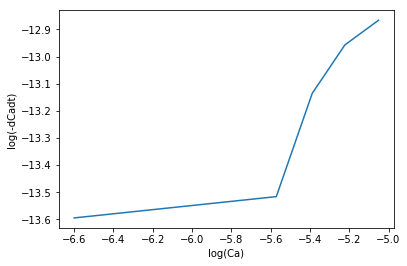

In [1]:
from pycse import deriv

dCadt = deriv(t1, Ca)

%matplotlib inline
import matplotlib.pyplot as plt

x = np.log(Ca)
y = np.log(-dCadt)
plt.plot(x, y)
plt.xlabel('log(Ca)')
plt.ylabel('log(-dCadt)')

We have to use some judgment here and remember that numerical derivatives are not that accurate at the end points. So, we will neglect the lower left data point that does not have the same trend as the other points. Another subtle point is that point is not the first point, but actually the last one that corresponds to the lowest concentration. We can use indexing to select all but the last point with x[0:-1].

Here is the data we will fit. It looks moderately linear.

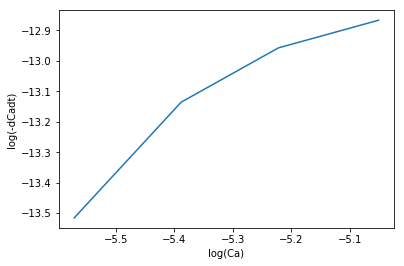

In [1]:
plt.plot(x[0:-1], y[0:-1])
plt.xlabel('log(Ca)')
plt.ylabel('log(-dCadt)')

To do the fitting we use regress.

In [1]:
from pycse import regress

x2 = x[0:-1]
y2 = y[0:-1]

X = np.column_stack([x2**0, x2])

p, pint, se = regress(X, y2, alpha=0.5)

kint = np.exp(pint[0])
alpha_int = pint[1]

print('k is in the range of {}'.format(kint))
print('alpha is in the range of {}'.format(alpha_int))

k is in the range of [ 0.00037195  0.00555431]
alpha is in the range of [ 0.98396255  1.49295965]

The &alpha; seems reasonable, it might be approximately a first order reaction. The units on that k are relevant to making the rate have units of mol/L/s with a rate law of $r = k C_A^\alpha$. To get the requested form of $r = k' P_A^\alpha$, we just recall that C = P / R / T. In this case we have $k = k' (1/RT)^\alpha$. The resulting k seems small, but remember that Pa is large compared to Ca.

In [1]:
alpha = p[1]
kp = np.exp(p[0]) * (1 / R / T)**alpha
print('kp = {}'.format(k))

kp = 2.2637245404825164e-09

We should always see our fit over the whole range of data. You can see here that the fit over the region we fitted is not too unreasonable, and justifies excluding the outlier since it is so far off the model. That could mean our model is not valid in that range, but it could also mean the data is inaccurate in that region.

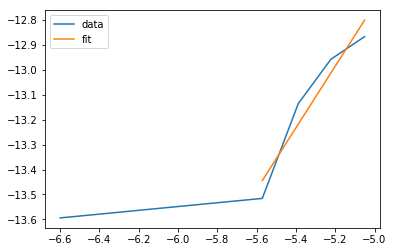

In [1]:
plt.plot(x, y)
plt.plot(x2, X @ p)
plt.legend(['data', 'fit'])

Finally, let's consider the original data. This is also a good idea. You can see here that we do a pretty good job modeling C\_A up to about 2000 and then the parameters do not do as good a job at the lower concentrations. That could be because our model is not very good at low concentration of A.

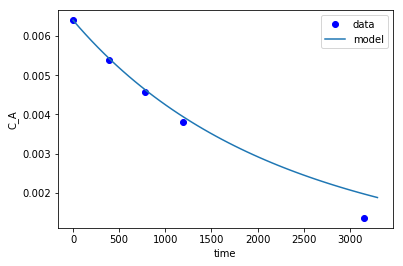

In [1]:
lnk, alpha = p
k = np.exp(lnk)

def ode(Ca, t):
    return -k * Ca**alpha

from scipy.integrate import odeint

tspan = np.linspace(0, 3300)
Casol = odeint(ode, Ca[0], tspan)

plt.plot(t1, Ca, 'bo ')
plt.plot(tspan, Casol)
plt.legend(['data', 'model'])
plt.xlabel('time')
plt.ylabel('C_A')

It is still not clear what the problem is at long time. It could be an insufficient model or inaccurate data.